In [1]:
# adhunter_v2
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from matplotlib.lines import Line2D

In [2]:
# Before running this code:
#
# A hmmer search was performed using the y1000+ genomes
#       Build hmm profile from ygob alignment of Ino2 genes: 
#               hmmbuild <hmmprofile> <ygob_alignment>
#       Run hmm search on genomes from y1000+:
#           cat ../genome_data/y1000p_pep_files_modified/*modified.pep | hmmsearch -o Ino4_search.out -A Ino4_search.align --tblout Ino4_search.tsv Ino4.hmm -
# 
# Extract significant genes found in hmmsearch using the get_gene_names function
# 
# Get sequences for significant genes
#       while IFS=, read -r gene species; do   species=$(echo "$species" | tr -d '\r');  grep -A 1 $gene ../GCN4_evolution/genome_data/y1000p_pep_files_modified/${species}_modified.pep; done < ino2_gene_names.csv > ino2_orthologs.fasta
# 
# Use the fasta file to identify domains with: https://www.ncbi.nlm.nih.gov/Structure/bwrpsb/bwrpsb.cgi
#
# Perform a reverse blast on the identified sequences with: 
#       ncbi-blast-2.15.0+/bin/blastp -query /global/scratch/users/claireleblanc/Msn4_evolution/ino2_orthologs.fasta -db saccharomyces_cerevisiae.final.blastdb -evalue 0.001 -outfmt 6 > reciprocal_blast_ino2.txt

In [3]:
# Used to extract gene names
def get_gene_names(in_file, out_file):
    with open(in_file, "r") as f:
        lines = f.readlines()
        
    genes = [line for line in lines if not line.startswith("#")]
    names = [gene.split()[0] for gene in genes]

    e_vals = [float(gene.split()[4]) for gene in genes]
    scores = [float(gene.split()[5]) for gene in genes]

    split_names = [name.split("_") for name in names]

    genes = [split_name[0] for split_name in split_names]
    species = ["_".join(split_name[1:]) for split_name in split_names]

    genes_species = pd.DataFrame((genes, species, e_vals, scores)).T
    genes_species.columns = ["gene","species","evalue", "scores"]
    genes_species = genes_species[genes_species["evalue"] < 0.001]

    genes_species[["gene", "species"]].to_csv(out_file, index=False, header=None)

# Domain filtering

In [4]:
all_lines = []

# Read in domain file
for i in range(1,2):
    domain_file = f"../Ino2/Ino2_domains.txt"
    with open(domain_file, "r") as f:
        lines = f.readlines()

    lines = [line.strip().split('\t') for line in lines if not line.startswith("#")]
    all_lines = all_lines + (lines[2:])

domains = pd.DataFrame(all_lines, columns=lines[1])
domains["name"] = [s.split('>')[-1] for s in domains["Query"]]
domains

,Query,Hit type,PSSM-ID,From,To,E-Value,Bitscore,Accession,Short name,Incomplete,Superfamily,name
0,Q#1 - >g002214.m1_yHMPu5000034874_tetrapisispo...,superfamily,469605,531,631,2.26421e-09,53.8961,cl00081,bHLH_SF superfamily,-,-,g002214.m1_yHMPu5000034874_tetrapisispora_blat...
1,Q#2 - >g000635.m1_yHMPu5000034723_candida_glab...,specific,381394,364,431,9.2436e-25,96.6532,cd11388,bHLH_ScINO2_like,-,cl00081,g000635.m1_yHMPu5000034723_candida_glabrata_18...
2,Q#3 - >g000355.m1_yHMPu5000034712_kluyveromyce...,superfamily,469605,294,370,3.89974e-09,52.7405,cl00081,bHLH_SF superfamily,C,-,g000355.m1_yHMPu5000034712_kluyveromyces_lacti...
3,Q#4 - >g004678.m1_kluyveromyces_lactis.final,superfamily,469605,294,370,3.89974e-09,52.7405,cl00081,bHLH_SF superfamily,C,-,g004678.m1_kluyveromyces_lactis.final
4,Q#5 - >g002630.m1_yHMPu5000034872_naumovozyma_...,specific,381394,321,389,1.31859e-15,70.8448,cd11388,bHLH_ScINO2_like,-,cl00081,g002630.m1_yHMPu5000034872_naumovozyma_dairene...
...,...,...,...,...,...,...,...,...,...,...,...,...
746,Q#717 - >g004613.m1_yHMPu5000034658_clavispora...,superfamily,469605,360,387,0.00170809,36.8942,cl00081,bHLH_SF superfamily,C,-,g004613.m1_yHMPu5000034658_clavispora_lusitani...
747,Q#718 - >g001307.m1_yHMPu5000034738_geotrichum...,superfamily,469605,397,471,5.19754e-15,69.8006,cl00081,bHLH_SF superfamily,-,-,g001307.m1_yHMPu5000034738_geotrichum_candidum...
748,Q#719 - >g003794.m1_yHMPu5000034623_pichia_nor...,specific,270355,4,277,3.43699e-127,379.22,cd13637,PBP2_Ca3427_like,-,cl21456,g003794.m1_yHMPu5000034623_pichia_norvegensis_...
749,Q#719 - >g003794.m1_yHMPu5000034623_pichia_nor...,superfamily,469605,624,716,5.86167e-05,42.023,cl00081,bHLH_SF superfamily,-,-,g003794.m1_yHMPu5000034623_pichia_norvegensis_...


In [5]:
# Identify cerevisiae domains
domains[["saccharomyces_cerevisiae" in s for s in domains["name"]]]

,Query,Hit type,PSSM-ID,From,To,E-Value,Bitscore,Accession,Short name,Incomplete,Superfamily,name
6,Q#8 - >g003839.m1_saccharomyces_cerevisiae.final,specific,381394,235,302,2.01371e-26,98.9644,cd11388,bHLH_ScINO2_like,-,cl00081,g003839.m1_saccharomyces_cerevisiae.final


In [6]:
# Look at top most common domains
domains["Short name"].value_counts()

Short name
bHLH_SF superfamily                               566
bHLH_ScINO2_like                                  135
PBP2_Ca3427_like                                   11
LapB                                                3
Periplasmic_Binding_Protein_Type_2 superfamily      3
PKc_like superfamily                                2
Atrophin-1 superfamily                              2
PTZ00372 superfamily                                1
DUF5401 superfamily                                 1
PSP1                                                1
HRD1 superfamily                                    1
serpin superfamily                                  1
GAL4                                                1
Spy superfamily                                     1
Herpes_BLLF1 superfamily                            1
CDC39 superfamily                                   1
STD1 superfamily                                    1
PRK13914 superfamily                                1
FlgD superfamily 

In [7]:
# Filter for domains
dna_binding_domain = domains[(domains["Short name"] == "bHLH_SF superfamily") | (domains["Superfamily"] == "cl00081")]

In [8]:
# Get gene and species DF
genes_species = pd.read_csv("../Ino2/Ino2_gene_names.csv", header=None)
genes_species.columns = ["gene", "species"]
genes_species["name"] = genes_species["gene"] + "_" + genes_species["species"]
genes_species

,gene,species,name
0,g002214.m1,yHMPu5000034874_tetrapisispora_blattae_190924....,g002214.m1_yHMPu5000034874_tetrapisispora_blat...
1,g000635.m1,yHMPu5000034723_candida_glabrata_180604.final,g000635.m1_yHMPu5000034723_candida_glabrata_18...
2,g000355.m1,yHMPu5000034712_kluyveromyces_lactis_var_lacti...,g000355.m1_yHMPu5000034712_kluyveromyces_lacti...
3,g004678.m1,kluyveromyces_lactis.final,g004678.m1_kluyveromyces_lactis.final
4,g002630.m1,yHMPu5000034872_naumovozyma_dairenensis_180604...,g002630.m1_yHMPu5000034872_naumovozyma_dairene...
...,...,...,...
715,g003946.m1,yHMPu5000037898_candida_kofuensis_190924.final,g003946.m1_yHMPu5000037898_candida_kofuensis_1...
716,g004613.m1,yHMPu5000034658_clavispora_lusitaniae_190924.f...,g004613.m1_yHMPu5000034658_clavispora_lusitani...
717,g001307.m1,yHMPu5000034738_geotrichum_candidum_190924.hap...,g001307.m1_yHMPu5000034738_geotrichum_candidum...
718,g003794.m1,yHMPu5000034623_pichia_norvegensis_160519.hapl...,g003794.m1_yHMPu5000034623_pichia_norvegensis_...


In [9]:
# Merge domain df with gene/species name DF
dna_binding_domain = genes_species.merge(dna_binding_domain, on="name")
dna_binding_domain.drop_duplicates("name")

,gene,species,name,Query,Hit type,PSSM-ID,From,To,E-Value,Bitscore,Accession,Short name,Incomplete,Superfamily
0,g002214.m1,yHMPu5000034874_tetrapisispora_blattae_190924....,g002214.m1_yHMPu5000034874_tetrapisispora_blat...,Q#1 - >g002214.m1_yHMPu5000034874_tetrapisispo...,superfamily,469605,531,631,2.26421e-09,53.8961,cl00081,bHLH_SF superfamily,-,-
1,g000635.m1,yHMPu5000034723_candida_glabrata_180604.final,g000635.m1_yHMPu5000034723_candida_glabrata_18...,Q#2 - >g000635.m1_yHMPu5000034723_candida_glab...,specific,381394,364,431,9.2436e-25,96.6532,cd11388,bHLH_ScINO2_like,-,cl00081
2,g000355.m1,yHMPu5000034712_kluyveromyces_lactis_var_lacti...,g000355.m1_yHMPu5000034712_kluyveromyces_lacti...,Q#3 - >g000355.m1_yHMPu5000034712_kluyveromyce...,superfamily,469605,294,370,3.89974e-09,52.7405,cl00081,bHLH_SF superfamily,C,-
3,g004678.m1,kluyveromyces_lactis.final,g004678.m1_kluyveromyces_lactis.final,Q#4 - >g004678.m1_kluyveromyces_lactis.final,superfamily,469605,294,370,3.89974e-09,52.7405,cl00081,bHLH_SF superfamily,C,-
4,g002630.m1,yHMPu5000034872_naumovozyma_dairenensis_180604...,g002630.m1_yHMPu5000034872_naumovozyma_dairene...,Q#5 - >g002630.m1_yHMPu5000034872_naumovozyma_...,specific,381394,321,389,1.31859e-15,70.8448,cd11388,bHLH_ScINO2_like,-,cl00081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,g003946.m1,yHMPu5000037898_candida_kofuensis_190924.final,g003946.m1_yHMPu5000037898_candida_kofuensis_1...,Q#716 - >g003946.m1_yHMPu5000037898_candida_ko...,superfamily,469605,367,394,0.000527218,38.435,cl00081,bHLH_SF superfamily,C,-
697,g004613.m1,yHMPu5000034658_clavispora_lusitaniae_190924.f...,g004613.m1_yHMPu5000034658_clavispora_lusitani...,Q#717 - >g004613.m1_yHMPu5000034658_clavispora...,superfamily,469605,360,387,0.00170809,36.8942,cl00081,bHLH_SF superfamily,C,-
698,g001307.m1,yHMPu5000034738_geotrichum_candidum_190924.hap...,g001307.m1_yHMPu5000034738_geotrichum_candidum...,Q#718 - >g001307.m1_yHMPu5000034738_geotrichum...,superfamily,469605,397,471,5.19754e-15,69.8006,cl00081,bHLH_SF superfamily,-,-
699,g003794.m1,yHMPu5000034623_pichia_norvegensis_160519.hapl...,g003794.m1_yHMPu5000034623_pichia_norvegensis_...,Q#719 - >g003794.m1_yHMPu5000034623_pichia_nor...,superfamily,469605,624,716,5.86167e-05,42.023,cl00081,bHLH_SF superfamily,-,-


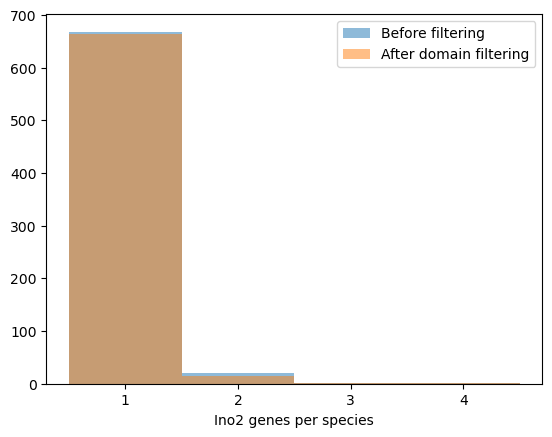

In [10]:
# Visualize genes per species
plt.hist(genes_species["species"].value_counts(), bins=[0.5, 1.5, 2.5, 3.5, 4.5], alpha=0.5, label="Before filtering")
plt.hist(dna_binding_domain["species"].value_counts(), bins=[0.5, 1.5, 2.5, 3.5, 4.5], alpha=0.5, label="After domain filtering")
plt.xticks([1,2,3,4])
plt.xlabel("Ino2 genes per species")
plt.legend()

# Reciprocal blast

In [11]:
# Read in blast data
blast_hits = pd.read_table("../Ino2/blast_Ino2.txt", header=None)
blast_hits.columns = ["gene_species_name", "blast_hit_gene_name","percent_identical", "alignment_length","num_mismatch","num_gaps","start_of_align_query","end_of_align_query","start_of_align_subj","end_of_align_subj","evalue","bitscore"]
blast_hits

,gene_species_name,blast_hit_gene_name,percent_identical,alignment_length,num_mismatch,num_gaps,start_of_align_query,end_of_align_query,start_of_align_subj,end_of_align_subj,evalue,bitscore
0,g002214.m1_yHMPu5000034874_tetrapisispora_blat...,g003839.m1,29.358,218,94,7,434,630,123,301,5.620000e-13,68.2
1,g000635.m1_yHMPu5000034723_candida_glabrata_18...,g003839.m1,38.424,203,101,7,230,431,123,302,9.010000e-26,104.0
2,g000635.m1_yHMPu5000034723_candida_glabrata_18...,g003839.m1,45.161,31,17,0,11,41,4,34,1.400000e-02,35.0
3,g000355.m1_yHMPu5000034712_kluyveromyces_lacti...,g003839.m1,22.879,389,207,10,1,384,1,301,6.230000e-15,72.8
4,g004678.m1_kluyveromyces_lactis.final,g003839.m1,22.879,389,207,10,1,384,1,301,6.230000e-15,72.8
...,...,...,...,...,...,...,...,...,...,...,...,...
865,g004613.m1_yHMPu5000034658_clavispora_lusitani...,g003839.m1,21.552,232,124,7,226,450,121,301,1.100000e-02,35.4
866,g001307.m1_yHMPu5000034738_geotrichum_candidum...,g002079.m1,30.108,93,59,1,393,485,41,127,1.420000e-06,45.8
867,g001307.m1_yHMPu5000034738_geotrichum_candidum...,g002988.m1,34.286,70,41,2,393,457,277,346,1.000000e-03,38.9
868,g001307.m1_yHMPu5000034738_geotrichum_candidum...,g004587.m1,31.092,119,77,3,341,459,196,309,2.000000e-03,38.5


Text(0.5, 0, 'Number of blast hits per gene')

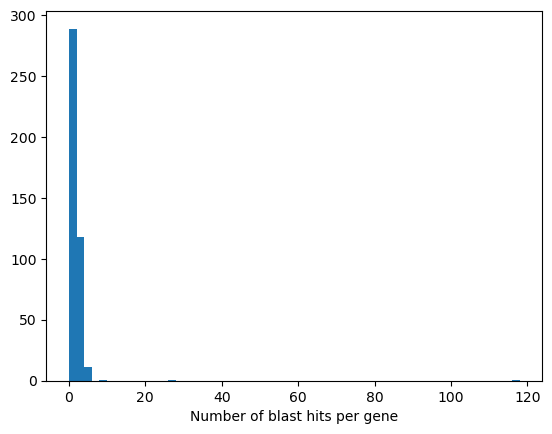

In [12]:
plt.hist(blast_hits["gene_species_name"].value_counts(), bins=np.arange(0,120,2))
plt.xlabel("Number of blast hits per gene")

In [13]:
# Sorts first on species, then on evalue (smallest first)
blast_hits = blast_hits.sort_values(["gene_species_name", "evalue"])

# Only keep the most significant blast hit
top_blast_hit = blast_hits.drop_duplicates("gene_species_name", keep="first")
top_blast_hit

,gene_species_name,blast_hit_gene_name,percent_identical,alignment_length,num_mismatch,num_gaps,start_of_align_query,end_of_align_query,start_of_align_subj,end_of_align_subj,evalue,bitscore
7,YDR123C_saccharomyces_cerevisiae.sgd,g003839.m1,100.000,60,0,0,1,60,1,60,5.190000e-38,125.0
507,g000004.m1_candida_dubliniensis.final,g003839.m1,25.203,369,159,19,29,354,10,304,1.880000e-04,40.4
299,g000020.m1_yHDO587_citeromyces_nyonsensis_1806...,g002079.m1,32.353,68,42,2,241,307,41,105,2.000000e-03,36.6
467,g000026.m1_yHMPu5000038121_candida_hungchunana...,g003862.m1,27.966,118,76,3,143,253,1693,1808,4.900000e-02,33.1
661,g000070.m1_yHMPu5000037926_candida_alai_190924...,g003919.m1,52.500,40,19,0,126,165,41,80,6.320000e-09,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...
109,g009511.m1_yHAB150_kazachstania_exigua_160519....,g003839.m1,37.037,189,104,3,236,415,121,303,1.840000e-24,100.0
416,g010245.m1_yHMPu5000035267_wickerhamomyces_lyn...,g003839.m1,27.586,203,115,9,145,337,122,302,6.330000e-04,38.9
451,g012466.m1_yHMPu5000035267_wickerhamomyces_lyn...,g002988.m1,32.292,96,48,3,251,329,252,347,6.000000e-03,36.2
392,g013856.m1_yHMPu5000035263_Candida_solani_SPAD...,g002079.m1,50.000,34,17,0,273,306,39,72,2.300000e-04,38.9


In [14]:
# Look at cerevisiae blast hits
blast_hits[["saccharomyces_cerevisiae" in s for s in blast_hits["gene_species_name"]]]

,gene_species_name,blast_hit_gene_name,percent_identical,alignment_length,num_mismatch,num_gaps,start_of_align_query,end_of_align_query,start_of_align_subj,end_of_align_subj,evalue,bitscore
7,YDR123C_saccharomyces_cerevisiae.sgd,g003839.m1,100.0,60,0,0,1,60,1,60,5.190000e-38,125.0
8,g003839.m1_saccharomyces_cerevisiae.final,g003839.m1,100.0,304,0,0,1,304,1,304,0.000000e+00,625.0


In [15]:
# Filter for genes with top blast hit to Ino2
top_blast_hit_ino2 = top_blast_hit[top_blast_hit["blast_hit_gene_name"] == "g003839.m1"]
top_blast_hit_ino2

,gene_species_name,blast_hit_gene_name,percent_identical,alignment_length,num_mismatch,num_gaps,start_of_align_query,end_of_align_query,start_of_align_subj,end_of_align_subj,evalue,bitscore
7,YDR123C_saccharomyces_cerevisiae.sgd,g003839.m1,100.000,60,0,0,1,60,1,60,5.190000e-38,125.0
507,g000004.m1_candida_dubliniensis.final,g003839.m1,25.203,369,159,19,29,354,10,304,1.880000e-04,40.4
133,g000097.m1_yHMPu5000034706_Kazachstania_psychr...,g003839.m1,45.745,94,51,0,311,404,208,301,5.490000e-22,93.6
305,g000170.m1_yHMPu5000035685_hanseniaspora_1_sp_...,g003839.m1,31.429,70,33,3,22,76,13,82,4.100000e-02,33.9
40,g000190.m1_yHMPu5000035651_Torulaspora_microel...,g003839.m1,31.642,335,158,10,1,296,1,303,3.870000e-37,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...
152,g007477.m1_yHAB150_kazachstania_exigua_160519....,g003839.m1,37.037,189,104,3,113,292,121,303,3.300000e-25,100.0
154,g008034.m1_yHAB150_kazachstania_exigua_160519....,g003839.m1,37.037,189,104,3,113,292,121,303,3.300000e-25,100.0
156,g008534.m1_yHAB150_kazachstania_exigua_160519....,g003839.m1,37.037,189,104,3,113,292,121,303,3.300000e-25,100.0
109,g009511.m1_yHAB150_kazachstania_exigua_160519....,g003839.m1,37.037,189,104,3,236,415,121,303,1.840000e-24,100.0


In [16]:
# Merge blast df with filtered domain df
top_blast_hit_ino2 = top_blast_hit_ino2.merge(dna_binding_domain, left_on="gene_species_name", right_on="name")

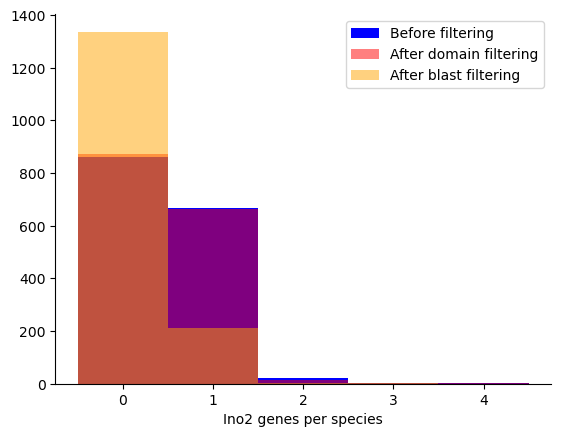

In [17]:
# Visualize genes per species
plt.hist(genes_species["species"].value_counts(), bins=[-0.5,0.5, 1.5, 2.5, 3.5, 4.5], label="Before filtering", color="blue")
plt.hist([0] * (1553 - len(set(genes_species["species"]))) , bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], color="blue")

plt.hist(dna_binding_domain["species"].value_counts(), bins=[-0.5,0.5, 1.5, 2.5, 3.5, 4.5], alpha=0.5, label="After domain filtering", color='red')
plt.hist([0] * (1553 - len(set(dna_binding_domain["species"]))), bins=[-0.5,0.5, 1.5, 2.5, 3.5, 4.5], alpha=0.5, color='red')

plt.hist(top_blast_hit_ino2.value_counts("species"), bins=[-0.5,0.5, 1.5, 2.5, 3.5], label="After blast filtering", alpha=0.5, color='orange')
plt.hist([0] * (1553 - len(set(top_blast_hit_ino2["species"]))), bins=[-0.5,0.5, 1.5, 2.5, 3.5], alpha=0.5, color='orange')

ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)  # Remove right spine
ax.spines['top'].set_visible(False) 

plt.xticks([0, 1,2,3,4])
plt.xlabel("Ino2 genes per species")
plt.legend()

In [18]:
# Read fasta sequences
with open("../Ino2/Ino2_orthologs.fasta", "r") as f:
    lines = f.readlines()

seqs = []
names = []
seq = ""

for line in lines:
    if line.startswith('>'):
        names.append(line.strip().replace(">", ""))
        if len(seq) > 0:
            seqs.append(seq)
            seq = ""
    else:
        seq += line.strip()
seqs.append(seq)

# Write to a csv file
ino2_df = pd.DataFrame({"name" : names, "aa_seq" : seqs})
ino2_df.to_csv("../Ino2/Ino2_orthologs.csv", index=False)
ino2_df

,name,aa_seq
0,g002214.m1_yHMPu5000034874_tetrapisispora_blat...,MQNLFDENQANRNKMSITTDNSTSKTTTNDDMFDFGSILGNTNTNN...
1,g000635.m1_yHMPu5000034723_candida_glabrata_18...,MMQDHQKSGVSSSQDLFDLFEQGNDIDFETAYQMLSGTLEESEPLQ...
2,g000355.m1_yHMPu5000034712_kluyveromyces_lacti...,MEAQSQGGLGSLLDMDLEGLDFETAYELINEKAELWDDSNDQFHMN...
3,g004678.m1_kluyveromyces_lactis.final,MEAQSQGGLGSLLDMDLEGLDFETAYELINEKAELWDDSNDQFHMN...
4,g002630.m1_yHMPu5000034872_naumovozyma_dairene...,MDNHHGSNSDILDMFDLGLGNEMDFETAYKMLSSLDETLIPSSHHT...
...,...,...
715,g003946.m1_yHMPu5000037898_candida_kofuensis_1...,MSSTATTTRELAGIMPANMNLNVFSHPPVKQKILENTTLEAHLMPV...
716,g004613.m1_yHMPu5000034658_clavispora_lusitani...,MSHTATSDVTPQMNLDAFGYPPSRQFMSHTGLSTQCREVPPQKKRK...
717,g001307.m1_yHMPu5000034738_geotrichum_candidum...,MNNNHNNHHSSAAAKKFGLPQSYTDFDFNIDFDTAFSNIPIDIPAS...
718,g003794.m1_yHMPu5000034623_pichia_norvegensis_...,MVTRIGYIPEHFSTPIAFAKKYGFYEQNGLSDFELIPYPSGSGHLI...


In [19]:
# Merge sequence df with filtered df
ino2_filtered_df = ino2_df.merge(top_blast_hit_ino2, left_on="name", right_on="gene_species_name")
ino2_filtered_df

,name_x,aa_seq,gene_species_name,blast_hit_gene_name,percent_identical,alignment_length,num_mismatch,num_gaps,start_of_align_query,end_of_align_query,...,Hit type,PSSM-ID,From,To,E-Value,Bitscore,Accession,Short name,Incomplete,Superfamily
0,g002214.m1_yHMPu5000034874_tetrapisispora_blat...,MQNLFDENQANRNKMSITTDNSTSKTTTNDDMFDFGSILGNTNTNN...,g002214.m1_yHMPu5000034874_tetrapisispora_blat...,g003839.m1,29.358,218,94,7,434,630,...,superfamily,469605,531,631,2.26421e-09,53.8961,cl00081,bHLH_SF superfamily,-,-
1,g000635.m1_yHMPu5000034723_candida_glabrata_18...,MMQDHQKSGVSSSQDLFDLFEQGNDIDFETAYQMLSGTLEESEPLQ...,g000635.m1_yHMPu5000034723_candida_glabrata_18...,g003839.m1,38.424,203,101,7,230,431,...,specific,381394,364,431,9.2436e-25,96.6532,cd11388,bHLH_ScINO2_like,-,cl00081
2,g000355.m1_yHMPu5000034712_kluyveromyces_lacti...,MEAQSQGGLGSLLDMDLEGLDFETAYELINEKAELWDDSNDQFHMN...,g000355.m1_yHMPu5000034712_kluyveromyces_lacti...,g003839.m1,22.879,389,207,10,1,384,...,superfamily,469605,294,370,3.89974e-09,52.7405,cl00081,bHLH_SF superfamily,C,-
3,g004678.m1_kluyveromyces_lactis.final,MEAQSQGGLGSLLDMDLEGLDFETAYELINEKAELWDDSNDQFHMN...,g004678.m1_kluyveromyces_lactis.final,g003839.m1,22.879,389,207,10,1,384,...,superfamily,469605,294,370,3.89974e-09,52.7405,cl00081,bHLH_SF superfamily,C,-
4,g002630.m1_yHMPu5000034872_naumovozyma_dairene...,MDNHHGSNSDILDMFDLGLGNEMDFETAYKMLSSLDETLIPSSHHT...,g002630.m1_yHMPu5000034872_naumovozyma_dairene...,g003839.m1,34.314,204,109,5,185,388,...,specific,381394,321,389,1.31859e-15,70.8448,cd11388,bHLH_ScINO2_like,-,cl00081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,g004454.m1_yHMPu5000034665_kodamaea_laetipori_...,MSNNLLELNSPLVNKLGSSDSLVSLLRERSTGQRNQSTQHTQSNQE...,g004454.m1_yHMPu5000034665_kodamaea_laetipori_...,g003839.m1,26.452,155,84,5,306,452,...,superfamily,469605,364,400,0.00485713,35.7386,cl00081,bHLH_SF superfamily,C,-
219,g004794.m1_yHMPu5000037898_candida_kofuensis_1...,MSSTATTTRELAGIMPANMNLNVFSHPPVKQKILENTTLEAHLMPV...,g004794.m1_yHMPu5000037898_candida_kofuensis_1...,g003839.m1,21.778,225,127,6,244,460,...,superfamily,469605,367,394,0.000477877,38.435,cl00081,bHLH_SF superfamily,C,-
220,g001980.m1_yHMPu5000041813_metschnikowia_lunat...,MSFTATATRETPPTSINLNVFSHPPVKRELLKNTTLESHLMPVITF...,g001980.m1_yHMPu5000041813_metschnikowia_lunat...,g003839.m1,25.556,90,42,2,360,449,...,superfamily,469605,359,393,0.000124564,39.9758,cl00081,bHLH_SF superfamily,C,-
221,g003946.m1_yHMPu5000037898_candida_kofuensis_1...,MSSTATTTRELAGIMPANMNLNVFSHPPVKQKILENTTLEAHLMPV...,g003946.m1_yHMPu5000037898_candida_kofuensis_1...,g003839.m1,21.333,225,128,6,244,460,...,superfamily,469605,367,394,0.000527218,38.435,cl00081,bHLH_SF superfamily,C,-


In [20]:
# Write filtered data to csv
ino2_filtered_df.to_csv("../Ino2/Ino2_blast_filtered.csv", index=False)

In [21]:
# Write filtered sequences to fasta
with open("../Ino2/Ino2_blast_filtered.fasta", "w+") as f:
    for i in ino2_filtered_df.index:
        f.write(">" + ino2_filtered_df.loc[i, "name_x"] + "\n")
        f.write(ino2_filtered_df.loc[i, "aa_seq"] + "\n")

### Run ADHunter on sequences to predict activation domains

# Make alignment conservation plot

In [22]:
# Read in ADHunter predicted activities
predictions = pd.read_csv('../Ino2/ADhunter_preds.csv', converters={'adhunter_centers':pd.eval, 'adhunter_preds':pd.eval})
predictions

,sequence,adhunter_centers,adhunter_preds
0,MQNLFDENQANRNKMSITTDNSTSKTTTNDDMFDFGSILGNTNTNN...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[67592.5, 63618.328125, 68282.59375, 106627.00..."
1,MMQDHQKSGVSSSQDLFDLFEQGNDIDFETAYQMLSGTLEESEPLQ...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[129607.78125, 112586.546875, 99242.390625, 91..."
2,MEAQSQGGLGSLLDMDLEGLDFETAYELINEKAELWDDSNDQFHMN...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[168005.703125, 166282.765625, 158990.875, 176..."
3,MEAQSQGGLGSLLDMDLEGLDFETAYELINEKAELWDDSNDQFHMN...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[168005.703125, 166282.765625, 158990.875, 176..."
4,MDNHHGSNSDILDMFDLGLGNEMDFETAYKMLSSLDETLIPSSHHT...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[185787.296875, 176278.375, 171335.484375, 162..."
...,...,...,...
216,MSNNLLELNSPLVNKLGSSDSLVSLLRERSTGQRNQSTQHTQSNQE...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[25368.22265625, 24574.09765625, 23672.3945312..."
217,MSSTATTTRELAGIMPANMNLNVFSHPPVKQKILENTTLEAHLMPV...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[40568.546875, 63622.71484375, 67899.2109375, ..."
218,MSFTATATRETPPTSINLNVFSHPPVKRELLKNTTLESHLMPVITF...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[24233.46484375, 29206.0546875, 27031.80078125..."
219,MSSTATTTRELAGIMPANMNLNVFSHPPVKQKILENTTLEAHLMPV...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[40568.546875, 63622.71484375, 67899.2109375, ..."


In [23]:
predictions["Length"] = predictions["sequence"].str.len()

In [24]:
# Get location of maximum activity --> Assume this is part of an AD
predictions["max_adhunter_pred"] = [np.max(i) for i in predictions['adhunter_preds']]
max_centers = []

for i in predictions.index:
    max_val = predictions.loc[i,"max_adhunter_pred"]

    # Get the index of the maximum predicted value
    max_idx = predictions.loc[i,"adhunter_preds"].index(max_val)

    # Get the corresponding amino acid residue position for that maximum value
    max_center = predictions.loc[i,"adhunter_centers"][max_idx]

    max_centers.append(max_center)

# Save locations of maximum activity values
predictions["max_adhunter_center"] = max_centers
predictions

,sequence,adhunter_centers,adhunter_preds,Length,max_adhunter_pred,max_adhunter_center
0,MQNLFDENQANRNKMSITTDNSTSKTTTNDDMFDFGSILGNTNTNN...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[67592.5, 63618.328125, 68282.59375, 106627.00...",634,233429.156250,52.0
1,MMQDHQKSGVSSSQDLFDLFEQGNDIDFETAYQMLSGTLEESEPLQ...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[129607.78125, 112586.546875, 99242.390625, 91...",432,191652.359375,28.0
2,MEAQSQGGLGSLLDMDLEGLDFETAYELINEKAELWDDSNDQFHMN...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[168005.703125, 166282.765625, 158990.875, 176...",385,242564.890625,28.0
3,MEAQSQGGLGSLLDMDLEGLDFETAYELINEKAELWDDSNDQFHMN...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[168005.703125, 166282.765625, 158990.875, 176...",385,242564.890625,28.0
4,MDNHHGSNSDILDMFDLGLGNEMDFETAYKMLSSLDETLIPSSHHT...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[185787.296875, 176278.375, 171335.484375, 162...",400,191906.171875,29.0
...,...,...,...,...,...,...
216,MSNNLLELNSPLVNKLGSSDSLVSLLRERSTGQRNQSTQHTQSNQE...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[25368.22265625, 24574.09765625, 23672.3945312...",468,191456.953125,48.0
217,MSSTATTTRELAGIMPANMNLNVFSHPPVKQKILENTTLEAHLMPV...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[40568.546875, 63622.71484375, 67899.2109375, ...",460,184299.218750,64.0
218,MSFTATATRETPPTSINLNVFSHPPVKRELLKNTTLESHLMPVITF...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[24233.46484375, 29206.0546875, 27031.80078125...",452,172652.000000,61.0
219,MSSTATTTRELAGIMPANMNLNVFSHPPVKQKILENTTLEAHLMPV...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[40568.546875, 63622.71484375, 67899.2109375, ...",460,184299.218750,64.0


Text(0.5, 0, 'Relative position of maximum ADHunter activity')

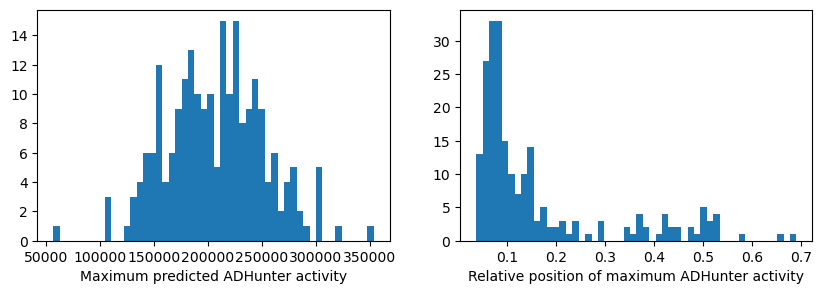

In [25]:
# Visualize location and distribution of maximum activities
fig, axs = plt.subplots(1,2,figsize=(10,3))
axs[0].hist(predictions["max_adhunter_pred"], bins=50)
axs[0].set_xlabel("Maximum predicted ADHunter activity")

axs[1].hist(predictions["max_adhunter_center"]/predictions["Length"], bins=50)
axs[1].set_xlabel("Relative position of maximum ADHunter activity")

In [26]:
# Code to get a 70aa region around the maximum predicted ADHunter activity
def get_high_activity_region(sequence, max_center):

    # If the max activity is 35aa or more away from both ends
    if (len(sequence) >= max_center + 35) & (max_center - 35 >= 0):
        region = sequence[max_center - 35 : max_center + 35]
    
    # If the max activity is close to the end
    elif (len(sequence) < max_center + 35):
        region = sequence[len(sequence)-70:]

    # If the max activity is close to the beginning
    else:
        region = sequence[:70]
        
    return region

In [27]:
# Extract AD regions for all sequences
predictions["AD_region"] = [get_high_activity_region(predictions.loc[i, "sequence"], int(predictions.loc[i, "max_adhunter_center"])) for i in predictions.index]

In [28]:
# Merge ADHunter predictions with filtered df
predictions_w_names = ino2_filtered_df.merge(predictions.drop_duplicates("sequence"), left_on="aa_seq", right_on="sequence")
predictions_w_names

,name_x,aa_seq,gene_species_name,blast_hit_gene_name,percent_identical,alignment_length,num_mismatch,num_gaps,start_of_align_query,end_of_align_query,...,Short name,Incomplete,Superfamily,sequence,adhunter_centers,adhunter_preds,Length,max_adhunter_pred,max_adhunter_center,AD_region
0,g002214.m1_yHMPu5000034874_tetrapisispora_blat...,MQNLFDENQANRNKMSITTDNSTSKTTTNDDMFDFGSILGNTNTNN...,g002214.m1_yHMPu5000034874_tetrapisispora_blat...,g003839.m1,29.358,218,94,7,434,630,...,bHLH_SF superfamily,-,-,MQNLFDENQANRNKMSITTDNSTSKTTTNDDMFDFGSILGNTNTNN...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[67592.5, 63618.328125, 68282.59375, 106627.00...",634,233429.156250,52.0,TTDNSTSKTTTNDDMFDFGSILGNTNTNNNEVNGAVNDIDNFDIDL...
1,g000635.m1_yHMPu5000034723_candida_glabrata_18...,MMQDHQKSGVSSSQDLFDLFEQGNDIDFETAYQMLSGTLEESEPLQ...,g000635.m1_yHMPu5000034723_candida_glabrata_18...,g003839.m1,38.424,203,101,7,230,431,...,bHLH_ScINO2_like,-,cl00081,MMQDHQKSGVSSSQDLFDLFEQGNDIDFETAYQMLSGTLEESEPLQ...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[129607.78125, 112586.546875, 99242.390625, 91...",432,191652.359375,28.0,MMQDHQKSGVSSSQDLFDLFEQGNDIDFETAYQMLSGTLEESEPLQ...
2,g000355.m1_yHMPu5000034712_kluyveromyces_lacti...,MEAQSQGGLGSLLDMDLEGLDFETAYELINEKAELWDDSNDQFHMN...,g000355.m1_yHMPu5000034712_kluyveromyces_lacti...,g003839.m1,22.879,389,207,10,1,384,...,bHLH_SF superfamily,C,-,MEAQSQGGLGSLLDMDLEGLDFETAYELINEKAELWDDSNDQFHMN...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[168005.703125, 166282.765625, 158990.875, 176...",385,242564.890625,28.0,MEAQSQGGLGSLLDMDLEGLDFETAYELINEKAELWDDSNDQFHMN...
3,g004678.m1_kluyveromyces_lactis.final,MEAQSQGGLGSLLDMDLEGLDFETAYELINEKAELWDDSNDQFHMN...,g004678.m1_kluyveromyces_lactis.final,g003839.m1,22.879,389,207,10,1,384,...,bHLH_SF superfamily,C,-,MEAQSQGGLGSLLDMDLEGLDFETAYELINEKAELWDDSNDQFHMN...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[168005.703125, 166282.765625, 158990.875, 176...",385,242564.890625,28.0,MEAQSQGGLGSLLDMDLEGLDFETAYELINEKAELWDDSNDQFHMN...
4,g002630.m1_yHMPu5000034872_naumovozyma_dairene...,MDNHHGSNSDILDMFDLGLGNEMDFETAYKMLSSLDETLIPSSHHT...,g002630.m1_yHMPu5000034872_naumovozyma_dairene...,g003839.m1,34.314,204,109,5,185,388,...,bHLH_ScINO2_like,-,cl00081,MDNHHGSNSDILDMFDLGLGNEMDFETAYKMLSSLDETLIPSSHHT...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[185787.296875, 176278.375, 171335.484375, 162...",400,191906.171875,29.0,MDNHHGSNSDILDMFDLGLGNEMDFETAYKMLSSLDETLIPSSHHT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,g004454.m1_yHMPu5000034665_kodamaea_laetipori_...,MSNNLLELNSPLVNKLGSSDSLVSLLRERSTGQRNQSTQHTQSNQE...,g004454.m1_yHMPu5000034665_kodamaea_laetipori_...,g003839.m1,26.452,155,84,5,306,452,...,bHLH_SF superfamily,C,-,MSNNLLELNSPLVNKLGSSDSLVSLLRERSTGQRNQSTQHTQSNQE...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[25368.22265625, 24574.09765625, 23672.3945312...",468,191456.953125,48.0,NKLGSSDSLVSLLRERSTGQRNQSTQHTQSNQEEPFLLDMLSADMD...
217,g004794.m1_yHMPu5000037898_candida_kofuensis_1...,MSSTATTTRELAGIMPANMNLNVFSHPPVKQKILENTTLEAHLMPV...,g004794.m1_yHMPu5000037898_candida_kofuensis_1...,g003839.m1,21.778,225,127,6,244,460,...,bHLH_SF superfamily,C,-,MSSTATTTRELAGIMPANMNLNVFSHPPVKQKILENTTLEAHLMPV...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[40568.546875, 63622.71484375, 67899.2109375, ...",460,184299.218750,64.0,KQKILENTTLEAHLMPVITSAKSSAPQPQLSDDEDIFNLDMVTMDM...
218,g001980.m1_yHMPu5000041813_metschnikowia_lunat...,MSFTATATRETPPTSINLNVFSHPPVKRELLKNTTLESHLMPVITF...,g001980.m1_yHMPu5000041813_metschnikowia_lunat...,g003839.m1,25.556,90,42,2,360,449,...,bHLH_SF superfamily,C,-,MSFTATATRETPPTSINLNVFSHPPVKRELLKNTTLESHLMPVITF...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[24233.46484375, 29206.0546875, 27031.80078125...",452,172652.000000,61.0,KRELLKNTTLESHLMPVITFLKPDTPPTQHSDDEDIFNLDMVTMDM...
219,g003946.m1_yHMPu5000037898_candida_kofuensis_1...,MSSTATTTRELAGIMPANMNLNVFSHPPVKQKILENTTLEAHLMPV..

In [29]:
# Make fasta file with only the ADregions
with open("../Ino2/Ino2_filtered_ADregions.fasta", "w+") as f:
    for i in predictions_w_names.index:
        f.write(">" + predictions_w_names.loc[i, "gene_species_name"] + "\n")
        f.write(predictions_w_names.loc[i, "AD_region"] + "\n")

In [30]:
# Colors for the alignment conservation plots
amino_acid_colors = {
    # Purples
    'F': '#FFA442',  
    'W': '#006CAF',
    'L': '#5B2B82',

    # Reds
    'D': '#E03839', 
    'E': '#FDA0A5', 

    # Blues
    'K': '#00B3E5',
    'R': '#00B3E5', 

    # black
    'S': '#000000',  
    'P': '#000000',  

    # greys
    'A': '#787878', 
    'V': '#787878',  
    'I': '#787878',  
    'M': '#787878', 
    'T': '#787878', 
    'G': '#787878',  
    'C': '#787878', 
    'N': '#787878', 
    'Q': '#787878', 
    'H': '#787878',  
    'Y': '#787878', 
    'X' : '#787878',
    '-': "#FFFFFF"
}


In [31]:
# Code to make alignment conservation plots
def make_alignment_conservation_plot(alignment_file, output_file, remove_gaps=False):
    
    # Read in alignment file
    with open(alignment_file, "r") as f:
        lines = f.readlines()

    names = []
    seqs = []
    seq = ""

    for line in lines:
        if line.startswith(">"):
            names.append(line.strip().replace(">",""))
            if len(seq) > 0:
                seqs.append(seq)
                seq = ""
        else:
            seq += line.strip()

    seqs.append(seq)

    # This will determine the position of the amino acid in the plot (i.e. X at the bottom, - at the top)
    amino_acids = ['X','Y', 'H', 'Q','N', 'C', 'G', 'T', 'M', 'I', 'V', 'A', 'S',  'P', 'R', 'K', 'D', 'E', 'L', 'W', 'F', '-']

    # List of sequence positions - Each entry is a dictionary with amino acid counts at the position
    amino_acid_dicts = [{aa: 0 for aa in amino_acids}.copy() for _ in range(len(seqs[0]))]

    # Go through each sequence and count the amino acids at each position
    for seq in seqs: 
        for i, aa in enumerate(seq): 
            amino_acid_dicts[i][aa] += 1
    
    if remove_gaps: 
        filtered_aa_dict = []
        for aa_d in amino_acid_dicts:
            # Only include positions that are less than 90% gaps
            if aa_d['-'] < len(seqs) * .90:
                filtered_aa_dict.append(aa_d)
        amino_acid_dicts = filtered_aa_dict

    fig, ax = plt.subplots(figsize=(20,3))

    for i, count_dict in enumerate(amino_acid_dicts): 
        bottom = 0

        # Add to the bar for each amino acid
        for aa, count in count_dict.items():
            p = ax.bar(i, count/len(seqs), label=aa, bottom=bottom, color = amino_acid_colors[aa])
            bottom += count/len(seqs)

    ax.set_xlabel("Alignment position")
    ax.set_ylabel("Percent of sequences")

    custom_lines = []

    # Code to add a legend
    for color in list(amino_acid_colors.values()):
        custom_lines.append(Line2D([0], [0], color=color, lw=2))

    ax.legend(custom_lines, list(amino_acid_colors.keys()), bbox_to_anchor=(1.05, 1.05), fontsize=5.5)

    plt.savefig(output_file)

In [32]:
! mafft --auto ../Ino2/Ino2_filtered_ADregions.fasta > ../Ino2/Ino2_filtered_ADregions.mafft

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8176 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
  201 / 221
done.

Constructing a UPGMA tree (efffree=0) ... 
  210 / 221
done.

Progressive alignment 1/2... 
STEP    40 / 220 
Reallocating..done. *alloclen = 1142
STEP   220 / 220  h
done.

Making a distance matrix from msa.. 
  200 / 221
done.

Constructing a UPGMA tree (efffree=1) ... 
  210 / 221
done.

Progressive alignment 2/2... 
STEP    58 / 220 
Reallocating..done. *alloclen = 1142
STEP   220 / 220  h
done.

disttbfast (aa) Version 7.526
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)

distout=h
rescale = 1
dndpre (aa) Version 7.526
alg=X, model=BLOSUM62, 1.53, +0.12, -0.00, noshift, amax=0.0
0 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 2
sueff_global = 0.100000
nadd = 2
rescale = 1

  210 / 221
Segment   1/  

In [33]:
! mafft --auto ../Ino2/Ino2_blast_filtered.fasta > ../Ino2/Ino2_blast_filtered.mafft

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8176 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 15 ambiguous characters.
  201 / 223
done.

Constructing a UPGMA tree (efffree=0) ... 
  220 / 223
done.

Progressive alignment 1/2... 
STEP   177 / 222 
Reallocating..done. *alloclen = 2292
STEP   217 / 222 
Reallocating..done. *alloclen = 3604
STEP   222 / 222 
done.

Making a distance matrix from msa.. 
  200 / 223
done.

Constructing a UPGMA tree (efffree=1) ... 
  220 / 223
done.

Progressive alignment 2/2... 
STEP   178 / 222 
Reallocating..done. *alloclen = 2309
STEP   221 / 222 
Reallocating..done. *alloclen = 3779
STEP   222 / 222 
done.

disttbfast (aa) Version 7.526
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)

distout=h
rescale = 1
dndpre (aa) Version 7.526
alg=X, model=BLOSUM62, 1.53, +0.12, -0.00, noshift, amax=0.0
0 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nt

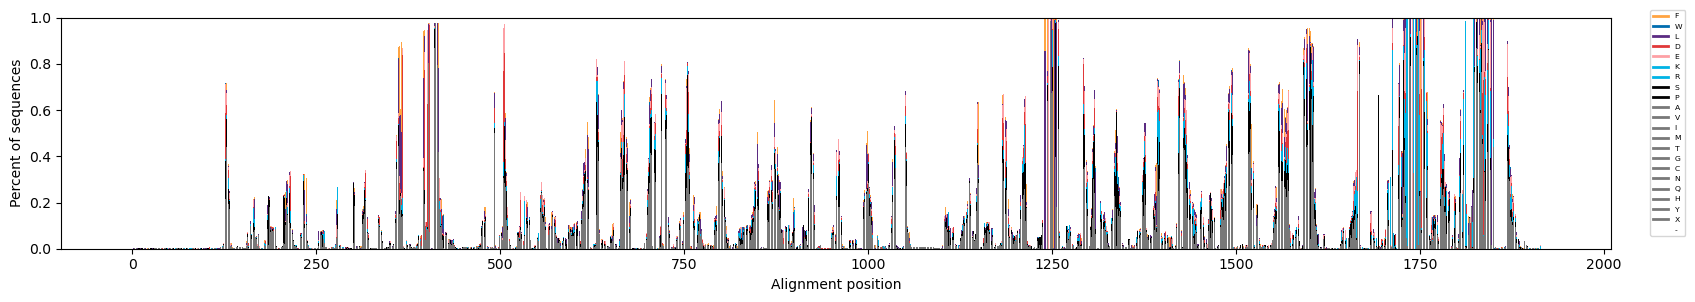

In [34]:
make_alignment_conservation_plot("../Ino2/../Ino2/Ino2_blast_filtered.mafft", "../Ino2/Ino2_full_alignment_conservation_plot.pdf")

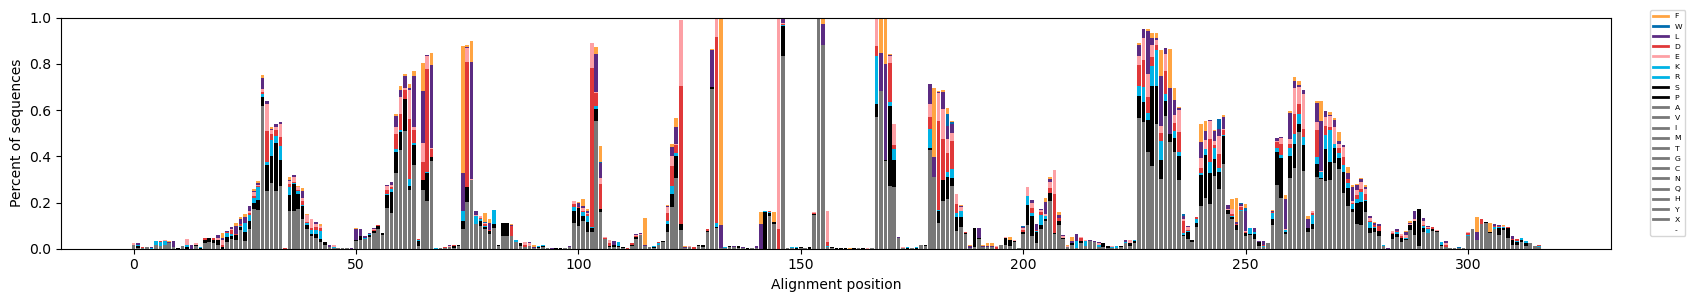

In [35]:
make_alignment_conservation_plot("../Ino2/Ino2_filtered_ADregions.mafft", "../Ino2/Ino2_ADregions_alignment_conservation_plot.pdf")

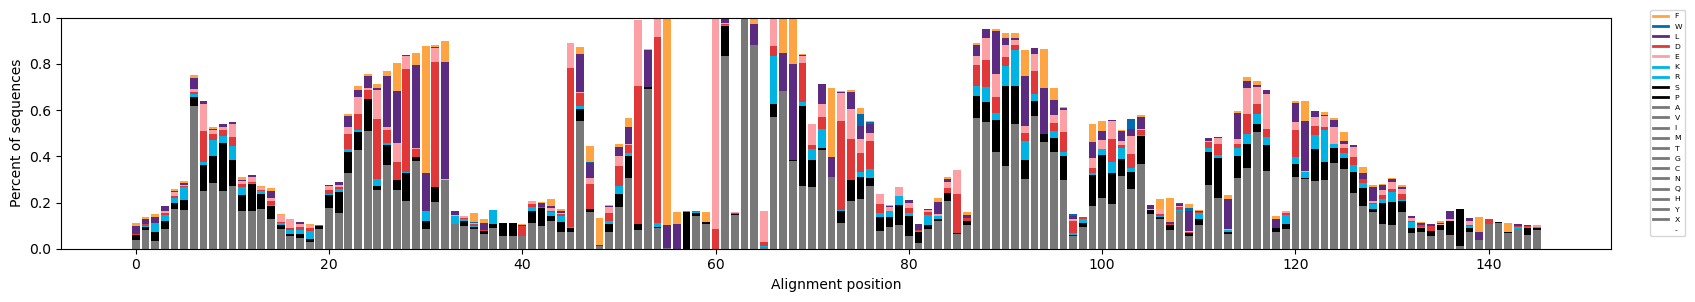

In [36]:
make_alignment_conservation_plot("../Ino2/Ino2_filtered_ADregions.mafft", "../Ino2/Ino2_ADregions_alignment_conservation_plot_no_gaps.pdf", remove_gaps=True)